# Análisis Comparativo de Eventos Volcánicos por Tipo


In [3]:
from pathlib import Path
import yaml
import obspy
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from scipy.fft import fft, fftfreq
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

PROJECT_ROOT = Path.cwd().parent

with open(PROJECT_ROOT / "config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

DATA_ROOT = Path(cfg["paths"]["data_root"])
LABELED_DATA = Path(cfg["paths"]["labeled_data"])

FIGURES_DIR = PROJECT_ROOT / cfg["paths"]["figures_output"]
TABLES_DIR = PROJECT_ROOT / cfg["paths"]["tables_output"]

FIGURES_DIR.mkdir(exist_ok=True)
TABLES_DIR.mkdir(exist_ok=True)

print("✓ Configuración cargada")
print(f"Datos: {LABELED_DATA}")
print(f"Figuras: {FIGURES_DIR}")

✓ Configuración cargada
Datos: K:\ckelar_label_data
Figuras: c:\Users\Disc\Desktop\pj\figures


## 1. Extracción de Características Detalladas

Extraemos características en tiempo y frecuencia para cada evento.

In [ ]:
def extract_time_features(trace):
    """Extrae características en el dominio del tiempo"""
    data = trace.data
    
    features = {
        
        'mean': np.mean(data),
        'std': np.std(data),
        'max': np.max(data),
        'min': np.min(data),
        'median': np.median(data),
        'range': np.ptp(data),
        
        
        'rms': np.sqrt(np.mean(data**2)),
        'energy': np.sum(data**2),
        'power': np.mean(data**2),
        
        
        'skewness': stats.skew(data),
        'kurtosis': stats.kurtosis(data),
        'zero_crossings': np.sum(np.diff(np.sign(data)) != 0),
        
        
        'variance': np.var(data),
        'mad': np.mean(np.abs(data - np.mean(data))),  
        'iqr': stats.iqr(data),  
        
        
        'q25': np.percentile(data, 25),
        'q75': np.percentile(data, 75),
    }
    
    return features
def extract_frequency_features(trace):
    """Extrae características en el dominio de la frecuencia"""
    data = trace.data
    fs = trace.stats.sampling_rate

    
    n = len(data)
    fft_vals = fft(data)
    fft_freqs = fftfreq(n, 1/fs)

    
    positive_freqs = fft_freqs[:n//2]
    positive_fft = np.abs(fft_vals[:n//2])

    if np.sum(positive_fft) == 0:
        return {}

    
    spectral_centroid = np.sum(positive_freqs * positive_fft) / np.sum(positive_fft)
    spectral_spread = np.sqrt(
        np.sum(((positive_freqs - spectral_centroid)**2) * positive_fft)
        / np.sum(positive_fft)
    )

    features = {
        
        'dominant_freq': positive_freqs[np.argmax(positive_fft)],
        'dominant_power': np.max(positive_fft),

        
        'energy_0_5hz': np.sum(positive_fft[(positive_freqs >= 0) & (positive_freqs < 5)]),
        'energy_5_10hz': np.sum(positive_fft[(positive_freqs >= 5) & (positive_freqs < 10)]),
        'energy_10_20hz': np.sum(positive_fft[(positive_freqs >= 10) & (positive_freqs < 20)]),
        'energy_20_50hz': np.sum(positive_fft[(positive_freqs >= 20) & (positive_freqs < 50)]),

        
        'spectral_centroid': spectral_centroid,
        'spectral_spread': spectral_spread,

        
        'spectral_entropy': stats.entropy(positive_fft + 1e-10),
        'total_spectral_energy': np.sum(positive_fft**2),
    }

    return features



print("Extrayendo características detalladas...")

all_features = []
event_types = []

for event_dir in LABELED_DATA.iterdir():
    if not event_dir.is_dir():
        continue
    
    event_type = event_dir.name
    print(f"  Procesando {event_type}...", end=" ")
    
    mseed_files = [f for f in event_dir.iterdir() if f.is_file()]
    
    for mseed_file in mseed_files:  
        try:
            st = obspy.read(str(mseed_file))
            tr = st[0]
            
            
            time_feats = extract_time_features(tr)
            freq_feats = extract_frequency_features(tr)
            
            
            features = {**time_feats, **freq_feats}
            features['tipo'] = event_type
            features['archivo'] = mseed_file.name
            features['duracion_s'] = float(tr.stats.endtime - tr.stats.starttime)
            
            all_features.append(features)
            event_types.append(event_type)
            
        except Exception as e:
            print(f"\nError en {mseed_file.name}: {e}")
            continue

    
    print(f"✓ ({len([f for f in all_features if f['tipo'] == event_type])} eventos)")

df_features = pd.DataFrame(all_features)

print(f"\n✓ Total de eventos analizados: {len(df_features)}")
print(f"✓ Características extraídas: {len(df_features.columns)}")
print(f"\nDistribución por tipo:")
print(df_features['tipo'].value_counts())

Extrayendo características detalladas...
  Procesando LP... ✓ (577 eventos)
  Procesando TC... ✓ (2198 eventos)
  Procesando TR... ✓ (471 eventos)
  Procesando VT... ✓ (2686 eventos)
  Procesando HY... ✓ (213 eventos)

✓ Total de eventos analizados: 6145
✓ Características extraídas: 30

Distribución por tipo:
tipo
VT    2686
TC    2198
LP     577
TR     471
HY     213
Name: count, dtype: int64


## 2. Análisis Estadístico Comparativo por Tipo


In [ ]:

numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()


summary_by_type = df_features.groupby('tipo')[numeric_features].agg(['mean', 'std', 'min', 'max'])

print("=" * 80)
print("RESUMEN ESTADÍSTICO POR TIPO DE EVENTO")
print("=" * 80)

for event_type in df_features['tipo'].unique():
    print(f"\n{'='*40}")
    print(f"TIPO: {event_type}")
    print(f"{'='*40}")
    
    subset = df_features[df_features['tipo'] == event_type]
    
    print(f"\nNúmero de eventos: {len(subset)}")
    print(f"\nCaracterísticas en tiempo:")
    print(f"  - Amplitud media: {subset['mean'].mean():.2e} ± {subset['mean'].std():.2e}")
    print(f"  - RMS: {subset['rms'].mean():.2e} ± {subset['rms'].std():.2e}")
    print(f"  - Energía: {subset['energy'].mean():.2e} ± {subset['energy'].std():.2e}")
    print(f"  - Kurtosis: {subset['kurtosis'].mean():.2f} ± {subset['kurtosis'].std():.2f}")
    print(f"  - Skewness: {subset['skewness'].mean():.2f} ± {subset['skewness'].std():.2f}")
    print(f"  - Cruces por cero: {subset['zero_crossings'].mean():.0f} ± {subset['zero_crossings'].std():.0f}")
    
    print(f"\nCaracterísticas en frecuencia:")
    print(f"  - Frecuencia dominante: {subset['dominant_freq'].mean():.2f} ± {subset['dominant_freq'].std():.2f} Hz")
    print(f"  - Centroide espectral: {subset['spectral_centroid'].mean():.2f} ± {subset['spectral_centroid'].std():.2f} Hz")
    print(f"  - Dispersión espectral: {subset['spectral_spread'].mean():.2f} ± {subset['spectral_spread'].std():.2f} Hz")
    print(f"  - Energía 0-5 Hz: {subset['energy_0_5hz'].mean():.2e}")
    print(f"  - Energía 5-10 Hz: {subset['energy_5_10hz'].mean():.2e}")
    print(f"  - Energía 10-20 Hz: {subset['energy_10_20hz'].mean():.2e}")
    print(f"  - Energía 20-50 Hz: {subset['energy_20_50hz'].mean():.2e}")


summary_path = TABLES_DIR / "resumen_caracteristicas_por_tipo.csv"
summary_by_type.to_csv(summary_path)
print(f"\n✓ Resumen guardado en: {summary_path}")

RESUMEN ESTADÍSTICO POR TIPO DE EVENTO

TIPO: LP

Número de eventos: 577

Características en tiempo:
  - Amplitud media: -1.67e+02 ± 1.01e+02
  - RMS: 2.42e+02 ± 5.67e+02
  - Energía: 1.19e+10 ± 2.15e+11
  - Kurtosis: 2.01 ± 8.49
  - Skewness: -0.01 ± 0.11
  - Cruces por cero: 462 ± 1686

Características en frecuencia:
  - Frecuencia dominante: 0.21 ± 2.65 Hz
  - Centroide espectral: 23.11 ± 17.81 Hz
  - Dispersión espectral: 28.37 ± 12.89 Hz
  - Energía 0-5 Hz: 1.91e+07
  - Energía 5-10 Hz: 2.61e+07
  - Energía 10-20 Hz: 1.33e+07
  - Energía 20-50 Hz: 1.44e+07

TIPO: TC

Número de eventos: 2198

Características en tiempo:
  - Amplitud media: -1.56e+02 ± 9.90e+01
  - RMS: 2.00e+02 ± 3.86e+02
  - Energía: 5.27e+09 ± 1.39e+11
  - Kurtosis: 3.67 ± 7.26
  - Skewness: 0.00 ± 0.14
  - Cruces por cero: 300 ± 1288

Características en frecuencia:
  - Frecuencia dominante: 0.11 ± 1.72 Hz
  - Centroide espectral: 19.70 ± 12.22 Hz
  - Dispersión espectral: 23.25 ± 9.23 Hz
  - Energía 0-5 Hz: 1.58e

## 3. Visualización Comparativa de Características

Visualizar

✓ Gráfico guardado en: c:\Users\Disc\Desktop\pj\figures\comparacion_caracteristicas_por_tipo.png


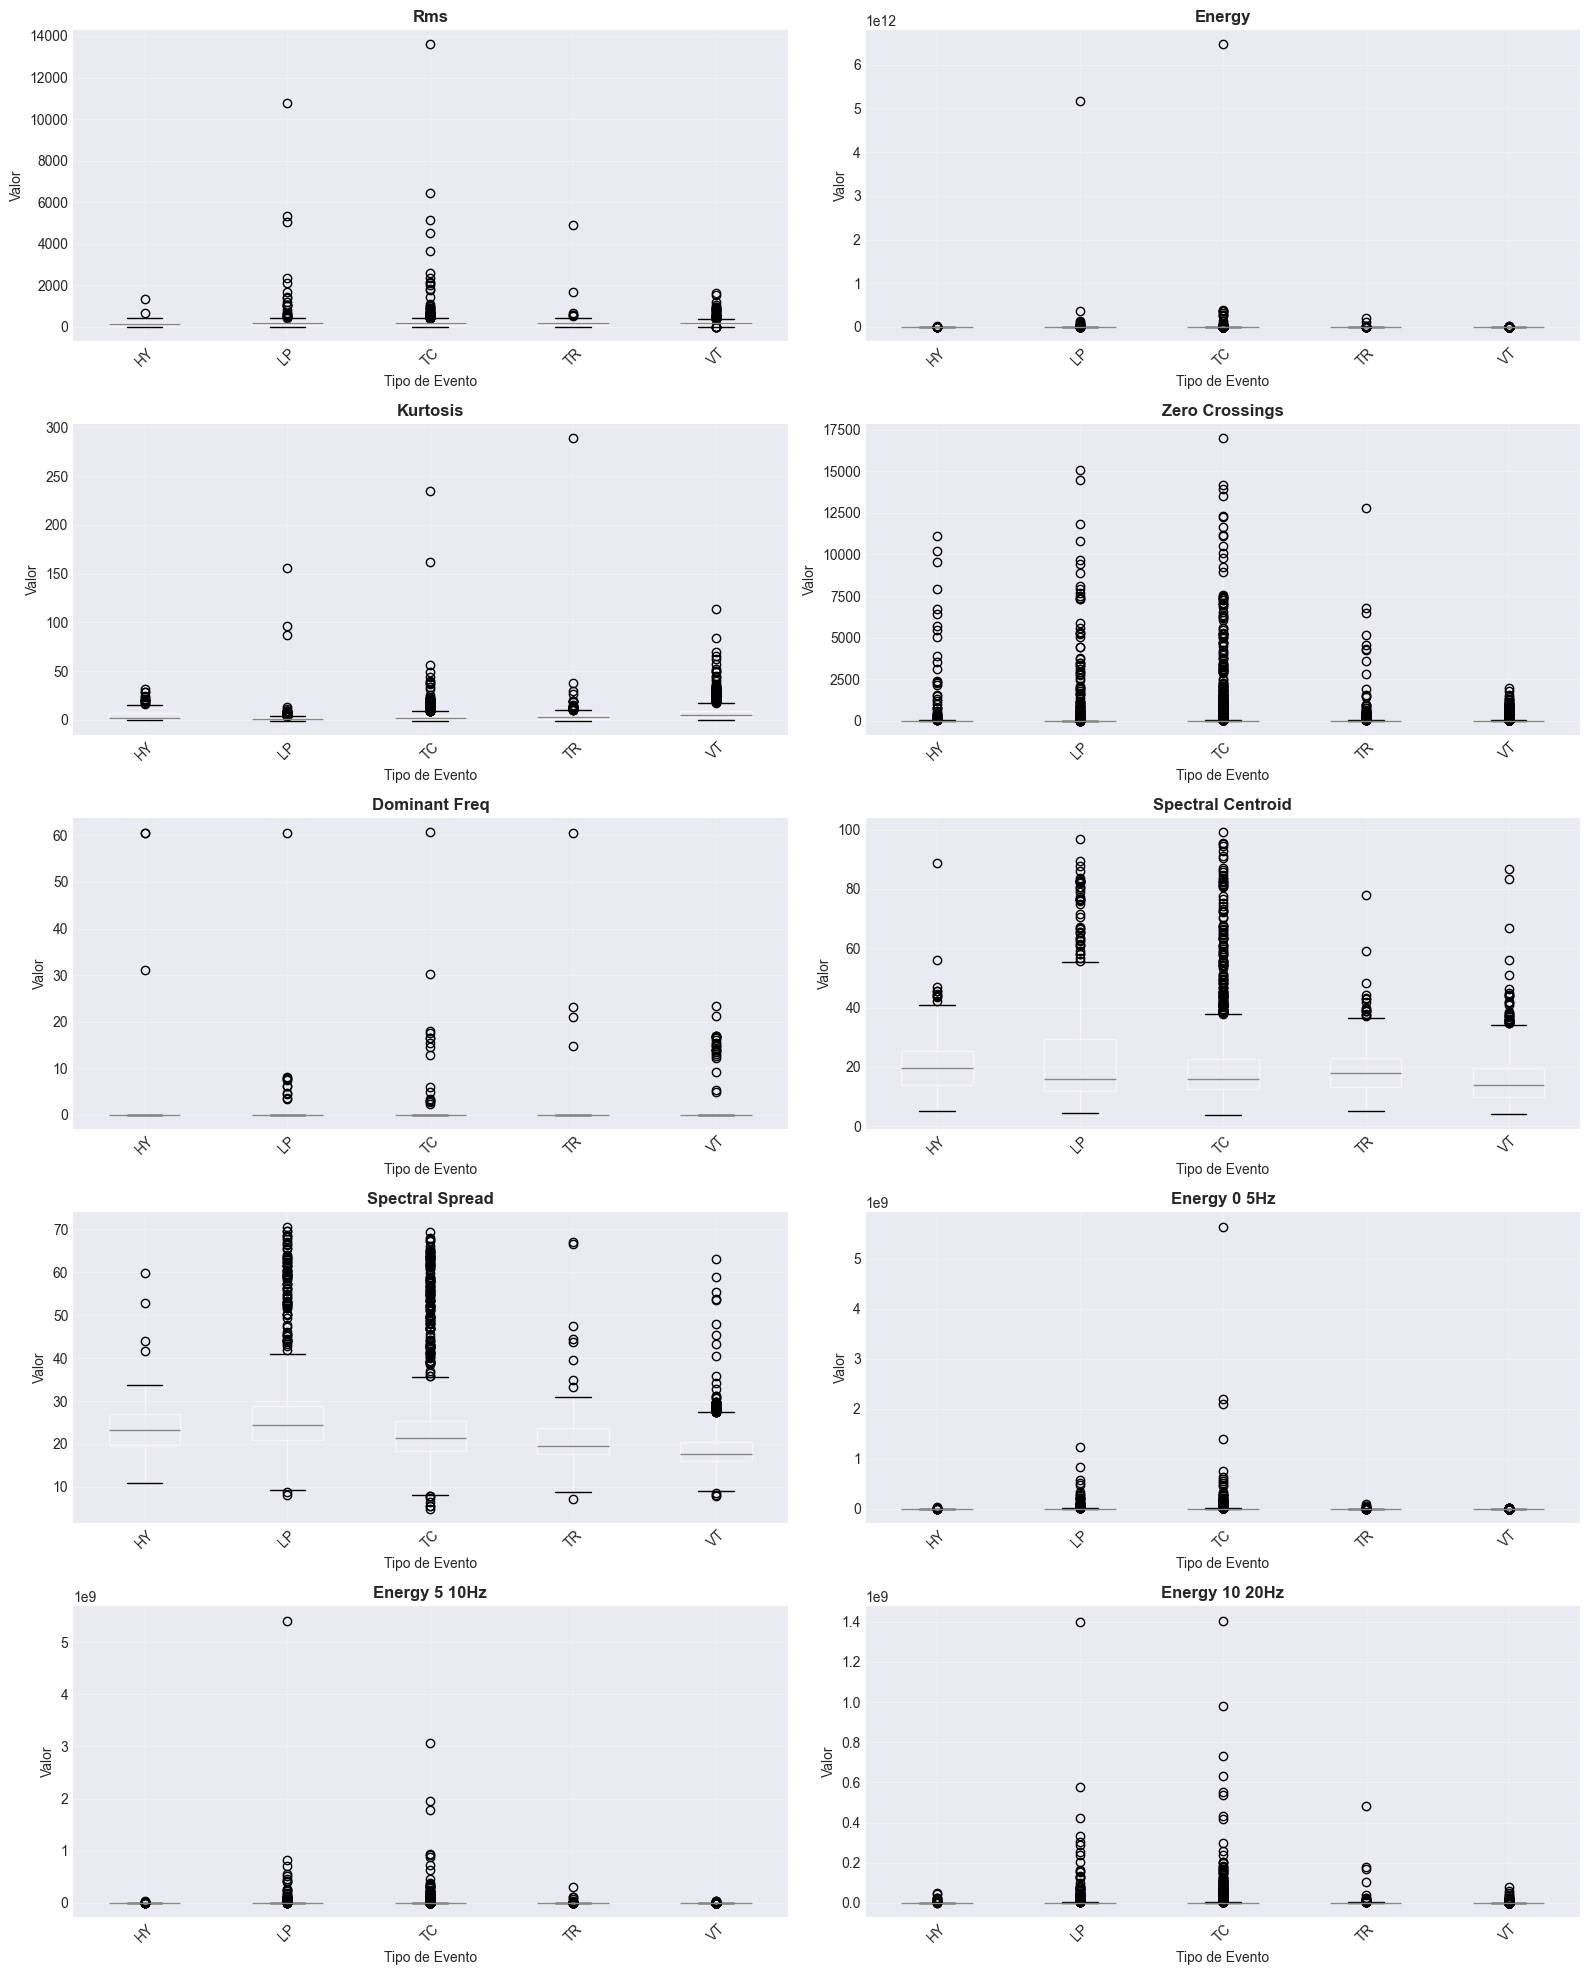

In [ ]:

key_features = [
    'rms', 'energy', 'kurtosis', 'zero_crossings',
    'dominant_freq', 'spectral_centroid', 'spectral_spread',
    'energy_0_5hz', 'energy_5_10hz', 'energy_10_20hz'
]


fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

fig.suptitle('Comparación de Características entre Tipos de Eventos', 
             fontsize=18, fontweight='bold', y=0.995)

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    
    df_features.boxplot(column=feature, by='tipo', ax=ax)
    ax.set_title(f'{feature.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Tipo de Evento', fontsize=10)
    ax.set_ylabel('Valor', fontsize=10)
    ax.get_figure().suptitle('')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
fig_path = FIGURES_DIR / "comparacion_caracteristicas_por_tipo.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Gráfico guardado en: {fig_path}")
plt.show()

## 4. Análisis de Distribuciones de Frecuencia por Tipo

✓ Gráfico guardado en: c:\Users\Disc\Desktop\pj\figures\distribucion_frecuencia_dominante.png


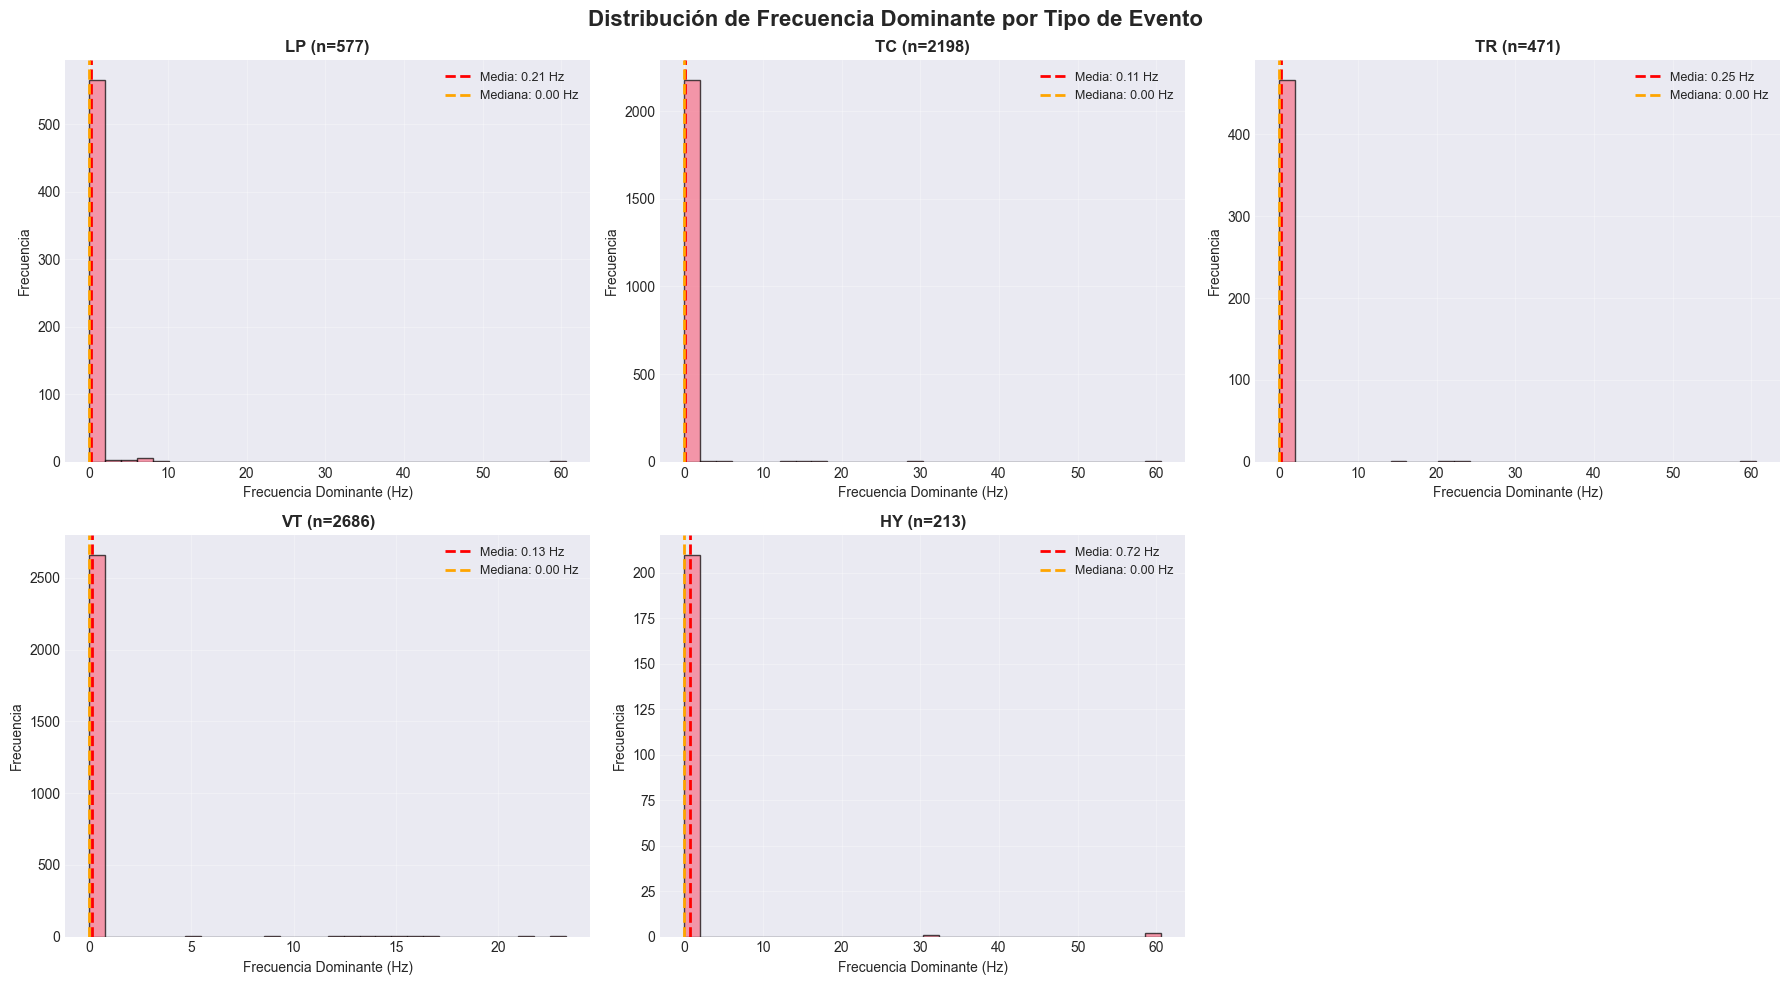

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

fig.suptitle('Distribución de Frecuencia Dominante por Tipo de Evento', 
             fontsize=16, fontweight='bold')

event_types_list = df_features['tipo'].unique()

for idx, event_type in enumerate(event_types_list):
    ax = axes[idx]
    subset = df_features[df_features['tipo'] == event_type]
    
    # Histograma
    ax.hist(subset['dominant_freq'], bins=30, alpha=0.7, edgecolor='black')
    ax.axvline(subset['dominant_freq'].mean(), color='red', 
               linestyle='--', linewidth=2, label=f'Media: {subset["dominant_freq"].mean():.2f} Hz')
    ax.axvline(subset['dominant_freq'].median(), color='orange', 
               linestyle='--', linewidth=2, label=f'Mediana: {subset["dominant_freq"].median():.2f} Hz')
    
    ax.set_title(f'{event_type} (n={len(subset)})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Frecuencia Dominante (Hz)', fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

if len(event_types_list) < 6:
    axes[5].axis('off')

plt.tight_layout()
fig_path = FIGURES_DIR / "distribucion_frecuencia_dominante.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Gráfico guardado en: {fig_path}")
plt.show()

## 5. Análisis de Energía Espectral por Bandas

✓ Gráfico guardado en: c:\Users\Disc\Desktop\pj\figures\energia_espectral_por_bandas.png


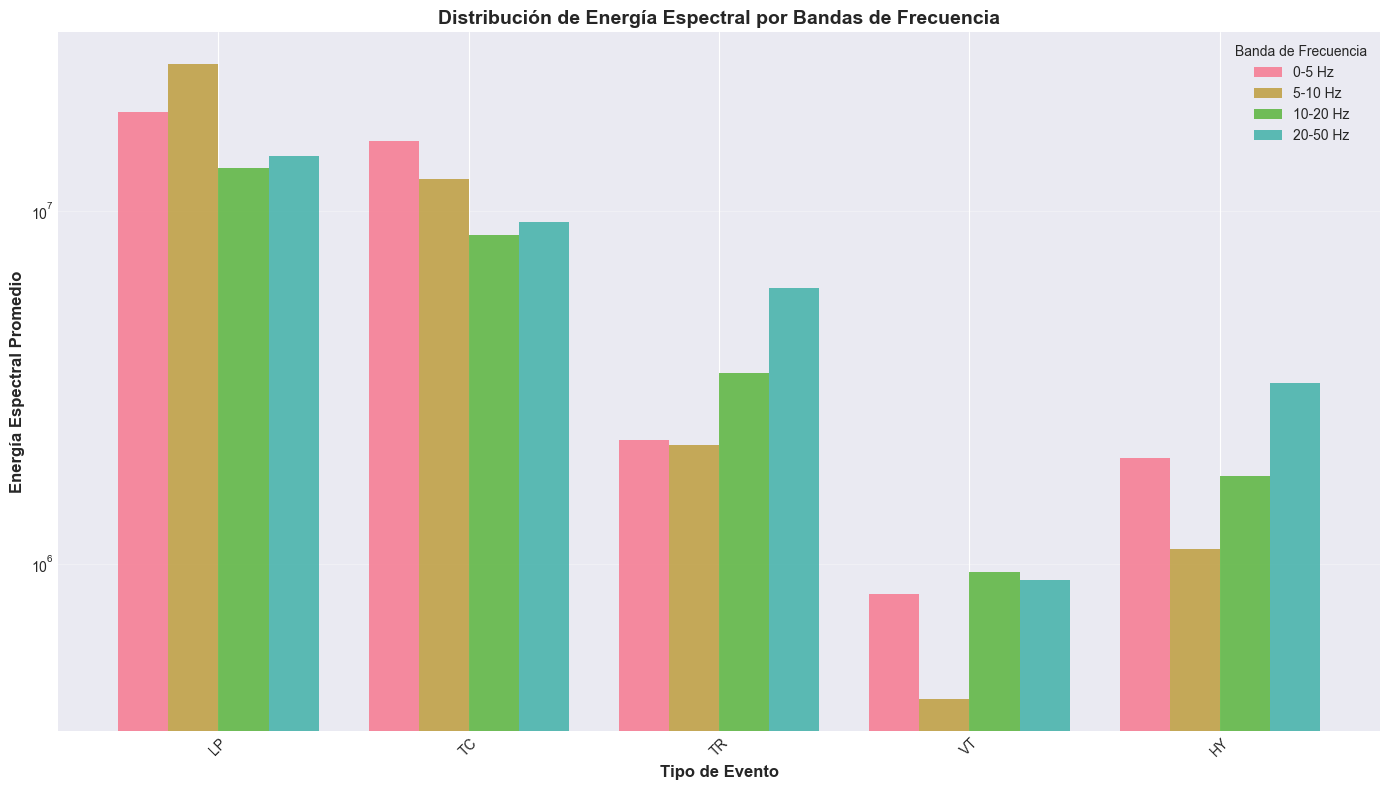


Energía promedio por banda:
          0-5 Hz       5-10 Hz      10-20 Hz      20-50 Hz
LP  1.909146e+07  2.612842e+07  1.328255e+07  1.436828e+07
TC  1.584628e+07  1.236799e+07  8.574645e+06  9.353903e+06
TR  2.242713e+06  2.176049e+06  3.474559e+06  6.053104e+06
VT  8.243927e+05  4.144273e+05  9.514323e+05  9.000836e+05
HY  1.996270e+06  1.107752e+06  1.780624e+06  3.260225e+06


In [14]:
energy_bands = ['energy_0_5hz', 'energy_5_10hz', 'energy_10_20hz', 'energy_20_50hz']
band_labels = ['0-5 Hz', '5-10 Hz', '10-20 Hz', '20-50 Hz']

energy_matrix = pd.DataFrame(
    index=df_features['tipo'].unique(),
    columns=band_labels
)

for event_type in df_features['tipo'].unique():
    subset = df_features[df_features['tipo'] == event_type]
    for band, label in zip(energy_bands, band_labels):
        energy_matrix.loc[event_type, label] = subset[band].mean()

energy_matrix = energy_matrix.astype(float)

fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(energy_matrix.index))
width = 0.2

for i, band in enumerate(band_labels):
    ax.bar(x + i*width, energy_matrix[band], width, label=band, alpha=0.8)

ax.set_xlabel('Tipo de Evento', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía Espectral Promedio', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Energía Espectral por Bandas de Frecuencia', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(energy_matrix.index, rotation=45)
ax.legend(title='Banda de Frecuencia', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_yscale('log')  

plt.tight_layout()
fig_path = FIGURES_DIR / "energia_espectral_por_bandas.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Gráfico guardado en: {fig_path}")
plt.show()

energy_matrix.to_csv(TABLES_DIR / "energia_por_bandas_y_tipo.csv")
print("\nEnergía promedio por banda:")
print(energy_matrix)

## 6. Análisis de Componentes Principales (PCA)

Reducción dimensional

Varianza explicada por componente:
  PC1: 52.17%
  PC2: 12.53%
  PC3: 9.68%
  PC4: 4.24%
  PC5: 4.04%
  Total (5 componentes): 82.66%

✓ Gráfico guardado en: c:\Users\Disc\Desktop\pj\figures\pca_separabilidad_eventos.png


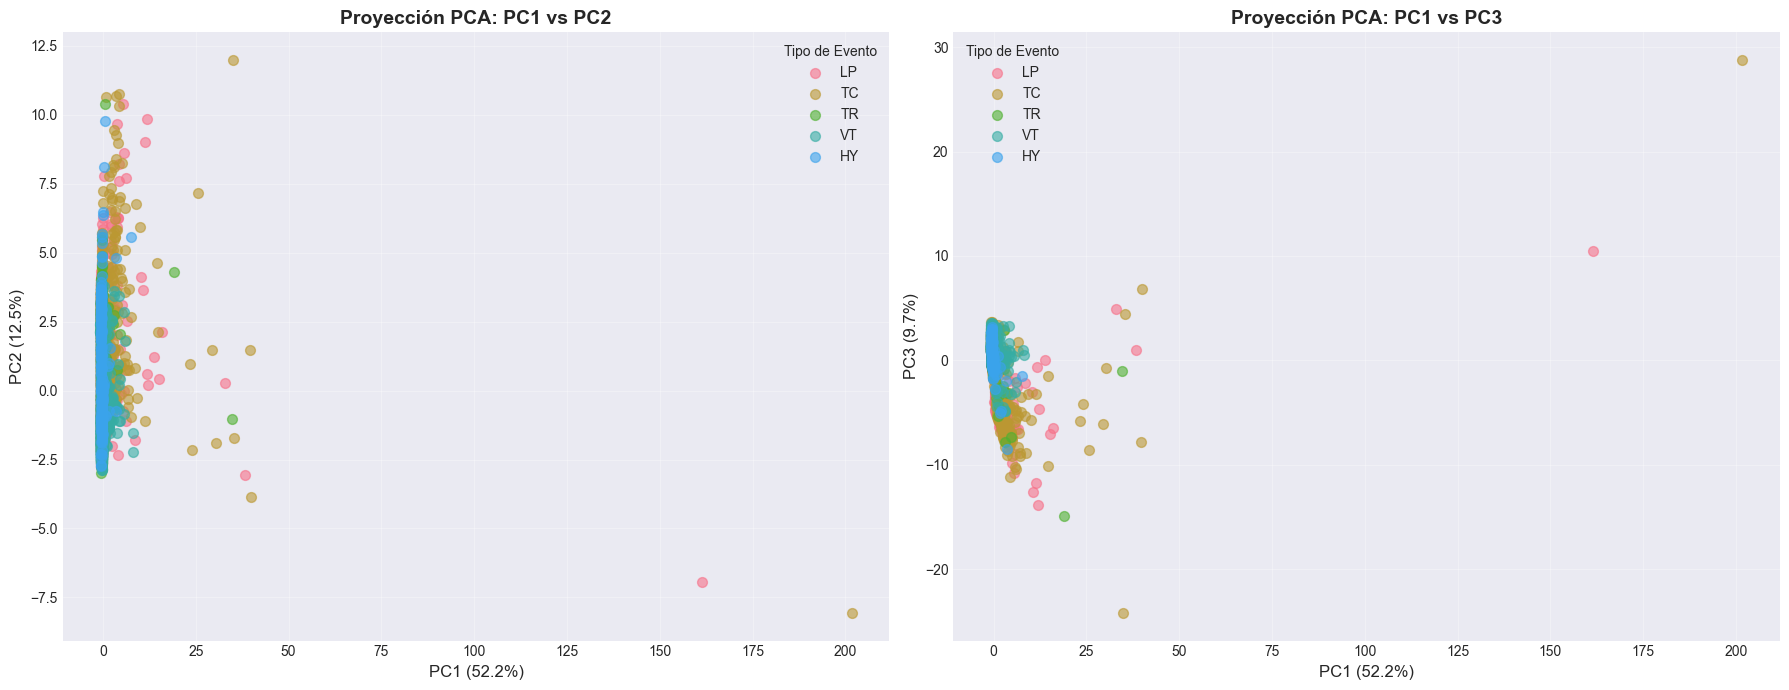


Top 10 características más importantes para PC1:
mad         0.261313
std         0.260550
max         0.258556
range       0.258137
iqr         0.257733
min         0.255875
power       0.252029
rms         0.247116
energy      0.246357
variance    0.246148
Name: PC1, dtype: float64


In [ ]:

feature_cols = [col for col in numeric_features if col != 'duracion_s']
X = df_features[feature_cols].fillna(0)
y = df_features['tipo']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=min(10, len(feature_cols)))
X_pca = pca.fit_transform(X_scaled)


pca_df = pd.DataFrame(
    data=X_pca[:, :3],
    columns=['PC1', 'PC2', 'PC3']
)
pca_df['tipo'] = y.values


print("Varianza explicada por componente:")
for i, var in enumerate(pca.explained_variance_ratio_[:5]):
    print(f"  PC{i+1}: {var*100:.2f}%")
print(f"  Total (5 componentes): {sum(pca.explained_variance_ratio_[:5])*100:.2f}%")


fig, axes = plt.subplots(1, 2, figsize=(18, 7))


for event_type in pca_df['tipo'].unique():
    subset = pca_df[pca_df['tipo'] == event_type]
    axes[0].scatter(subset['PC1'], subset['PC2'], label=event_type, alpha=0.6, s=50)

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[0].set_title('Proyección PCA: PC1 vs PC2', fontsize=14, fontweight='bold')
axes[0].legend(title='Tipo de Evento', fontsize=10)
axes[0].grid(True, alpha=0.3)


for event_type in pca_df['tipo'].unique():
    subset = pca_df[pca_df['tipo'] == event_type]
    axes[1].scatter(subset['PC1'], subset['PC3'], label=event_type, alpha=0.6, s=50)

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=12)
axes[1].set_title('Proyección PCA: PC1 vs PC3', fontsize=14, fontweight='bold')
axes[1].legend(title='Tipo de Evento', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
fig_path = FIGURES_DIR / "pca_separabilidad_eventos.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Gráfico guardado en: {fig_path}")
plt.show()


loadings = pd.DataFrame(
    pca.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=feature_cols
)


print("\nTop 10 características más importantes para PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False).head(10))

## 7. Tests Estadísticos entre Grupos

In [ ]:
from scipy.stats import f_oneway, kruskal
from itertools import combinations


test_features = [
    'rms', 'energy', 'dominant_freq', 'spectral_centroid',
    'zero_crossings', 'kurtosis'
]

print("=" * 80)
print("TESTS ESTADÍSTICOS ENTRE GRUPOS (ANOVA / Kruskal-Wallis)")
print("=" * 80)

anova_results = []

for feature in test_features:
    
    groups = [df_features[df_features['tipo'] == et][feature].dropna().values 
              for et in df_features['tipo'].unique()]
    
    
    f_stat, p_anova = f_oneway(*groups)
    
    
    h_stat, p_kruskal = kruskal(*groups)
    
    anova_results.append({
        'caracteristica': feature,
        'f_statistic': f_stat,
        'p_value_anova': p_anova,
        'h_statistic': h_stat,
        'p_value_kruskal': p_kruskal,
        'significativo': 'Sí' if p_anova < 0.05 else 'No'
    })
    
    print(f"\n{feature}:")
    print(f"  ANOVA:          F={f_stat:.2f}, p={p_anova:.4f}")
    print(f"  Kruskal-Wallis: H={h_stat:.2f}, p={p_kruskal:.4f}")
    print(f"  {'✓ Diferencias significativas' if p_anova < 0.05 else '✗ No significativo (α=0.05)'}")


anova_df = pd.DataFrame(anova_results)
anova_df.to_csv(TABLES_DIR / "tests_estadisticos_entre_grupos.csv", index=False)
print(f"\n✓ Resultados guardados en: {TABLES_DIR / 'tests_estadisticos_entre_grupos.csv'}")


print("\n" + "="*80)
print("TESTS POST-HOC (Comparaciones pareadas con t-test)")
print("="*80)

from scipy.stats import ttest_ind

event_types_list = df_features['tipo'].unique()
pairs = list(combinations(event_types_list, 2))


feature = 'dominant_freq'
print(f"\nCaracterística: {feature}")
print("-" * 60)

posthoc_results = []

for type1, type2 in pairs:
    group1 = df_features[df_features['tipo'] == type1][feature].dropna()
    group2 = df_features[df_features['tipo'] == type2][feature].dropna()
    
    t_stat, p_val = ttest_ind(group1, group2)
    
    posthoc_results.append({
        'comparacion': f"{type1} vs {type2}",
        't_statistic': t_stat,
        'p_value': p_val,
        'significativo': 'Sí' if p_val < 0.05 else 'No',
        'diferencia_medias': group1.mean() - group2.mean()
    })
    
    sig_marker = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"{type1:6s} vs {type2:6s}: t={t_stat:7.2f}, p={p_val:.4f} {sig_marker}")

posthoc_df = pd.DataFrame(posthoc_results)
posthoc_df.to_csv(TABLES_DIR / "tests_posthoc_pareados.csv", index=False)
print(f"\n✓ Resultados post-hoc guardados")

TESTS ESTADÍSTICOS ENTRE GRUPOS (ANOVA / Kruskal-Wallis)

rms:
  ANOVA:          F=5.50, p=0.0002
  Kruskal-Wallis: H=92.55, p=0.0000
  ✓ Diferencias significativas

energy:
  ANOVA:          F=1.80, p=0.1258
  Kruskal-Wallis: H=772.36, p=0.0000
  ✗ No significativo (α=0.05)

dominant_freq:
  ANOVA:          F=4.25, p=0.0019
  Kruskal-Wallis: H=6.81, p=0.1461
  ✓ Diferencias significativas

spectral_centroid:
  ANOVA:          F=94.92, p=0.0000
  Kruskal-Wallis: H=322.64, p=0.0000
  ✓ Diferencias significativas

zero_crossings:
  ANOVA:          F=34.30, p=0.0000
  Kruskal-Wallis: H=1.39, p=0.8467
  ✓ Diferencias significativas

kurtosis:
  ANOVA:          F=88.60, p=0.0000
  Kruskal-Wallis: H=1481.87, p=0.0000
  ✓ Diferencias significativas

✓ Resultados guardados en: c:\Users\Disc\Desktop\pj\tables\tests_estadisticos_entre_grupos.csv

TESTS POST-HOC (Comparaciones pareadas con t-test)

Característica: dominant_freq
------------------------------------------------------------
LP     v

## 8. Matriz de Similitud entre Tipos de Eventos

✓ Gráfico guardado en: c:\Users\Disc\Desktop\pj\figures\matriz_similitud_eventos.png


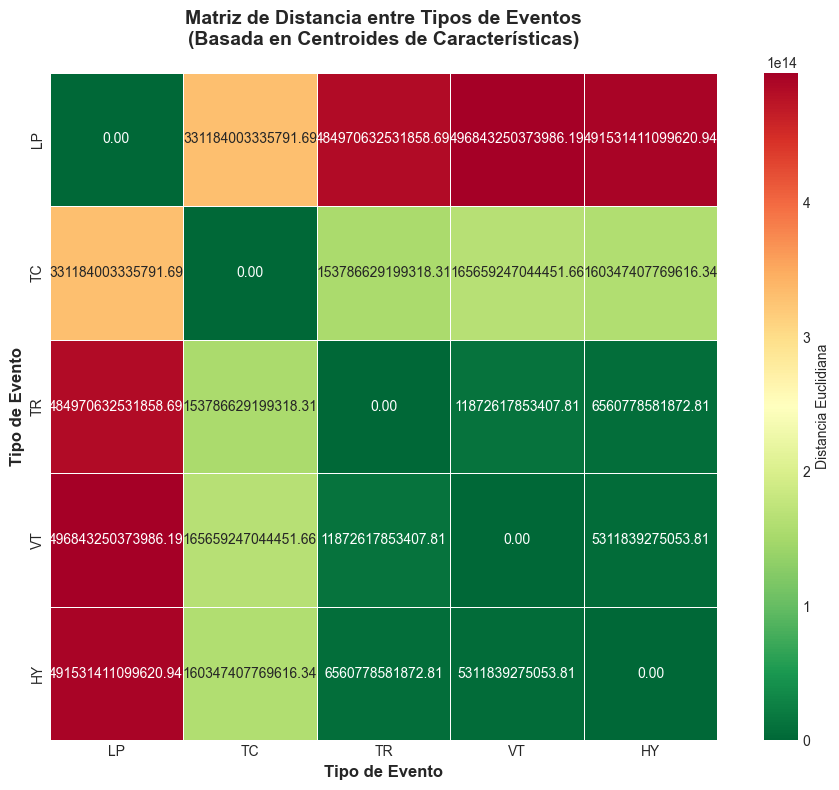


Matriz de distancias entre eventos:
              LP            TC            TR            VT            HY
LP  0.000000e+00  3.311840e+14  4.849706e+14  4.968433e+14  4.915314e+14
TC  3.311840e+14  0.000000e+00  1.537866e+14  1.656592e+14  1.603474e+14
TR  4.849706e+14  1.537866e+14  0.000000e+00  1.187262e+13  6.560779e+12
VT  4.968433e+14  1.656592e+14  1.187262e+13  0.000000e+00  5.311839e+12
HY  4.915314e+14  1.603474e+14  6.560779e+12  5.311839e+12  0.000000e+00

PARES MÁS SIMILARES (menor distancia):
LP - TC: 331184003335791.69
LP - TR: 484970632531858.69
LP - VT: 496843250373986.19
LP - HY: 491531411099620.94
TC - TR: 153786629199318.31
TC - VT: 165659247044451.66
TC - HY: 160347407769616.34
TR - VT: 11872617853407.81
TR - HY: 6560778581872.81
VT - HY: 5311839275053.81

✓ Par MÁS SIMILAR: VT - HY (distancia: 5311839275053.81)
✓ Par MÁS DIFERENTE: LP - VT (distancia: 496843250373986.19)


In [ ]:
from scipy.spatial.distance import pdist, squareform


event_types_list = df_features['tipo'].unique()
centroids = {}

for event_type in event_types_list:
    subset = df_features[df_features['tipo'] == event_type]
    centroid = subset[feature_cols].mean().values
    centroids[event_type] = centroid


centroid_matrix = np.array([centroids[et] for et in event_types_list])
distances = squareform(pdist(centroid_matrix, metric='euclidean'))


similarity_matrix = pd.DataFrame(
    distances,
    index=event_types_list,
    columns=event_types_list
)


fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    similarity_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn_r',
    square=True,
    cbar_kws={'label': 'Distancia Euclidiana'},
    linewidths=0.5,
    ax=ax
)

ax.set_title('Matriz de Distancia entre Tipos de Eventos\n(Basada en Centroides de Características)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Tipo de Evento', fontsize=12, fontweight='bold')
ax.set_ylabel('Tipo de Evento', fontsize=12, fontweight='bold')

plt.tight_layout()
fig_path = FIGURES_DIR / "matriz_similitud_eventos.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Gráfico guardado en: {fig_path}")
plt.show()

similarity_matrix.to_csv(TABLES_DIR / "matriz_distancias_eventos.csv")
print(f"\nMatriz de distancias entre eventos:")
print(similarity_matrix)


print("\n" + "="*60)
print("PARES MÁS SIMILARES (menor distancia):")
print("="*60)
for i in range(len(event_types_list)):
    for j in range(i+1, len(event_types_list)):
        dist = similarity_matrix.iloc[i, j]
        print(f"{event_types_list[i]} - {event_types_list[j]}: {dist:.2f}")


mask = np.triu(np.ones_like(similarity_matrix, dtype=bool), k=1)
distances_upper = similarity_matrix.where(mask)

min_idx = distances_upper.stack().idxmin()
max_idx = distances_upper.stack().idxmax()

print(f"\n✓ Par MÁS SIMILAR: {min_idx[0]} - {min_idx[1]} (distancia: {similarity_matrix.loc[min_idx]:.2f})")
print(f"✓ Par MÁS DIFERENTE: {max_idx[0]} - {max_idx[1]} (distancia: {similarity_matrix.loc[max_idx]:.2f})")

## 9. Visualización de Señales Representativas

Mostramos ejemplos de formas de onda típicas de cada tipo de evento.

✓ Gráfico guardado en: c:\Users\Disc\Desktop\pj\figures\senales_representativas_por_tipo.png


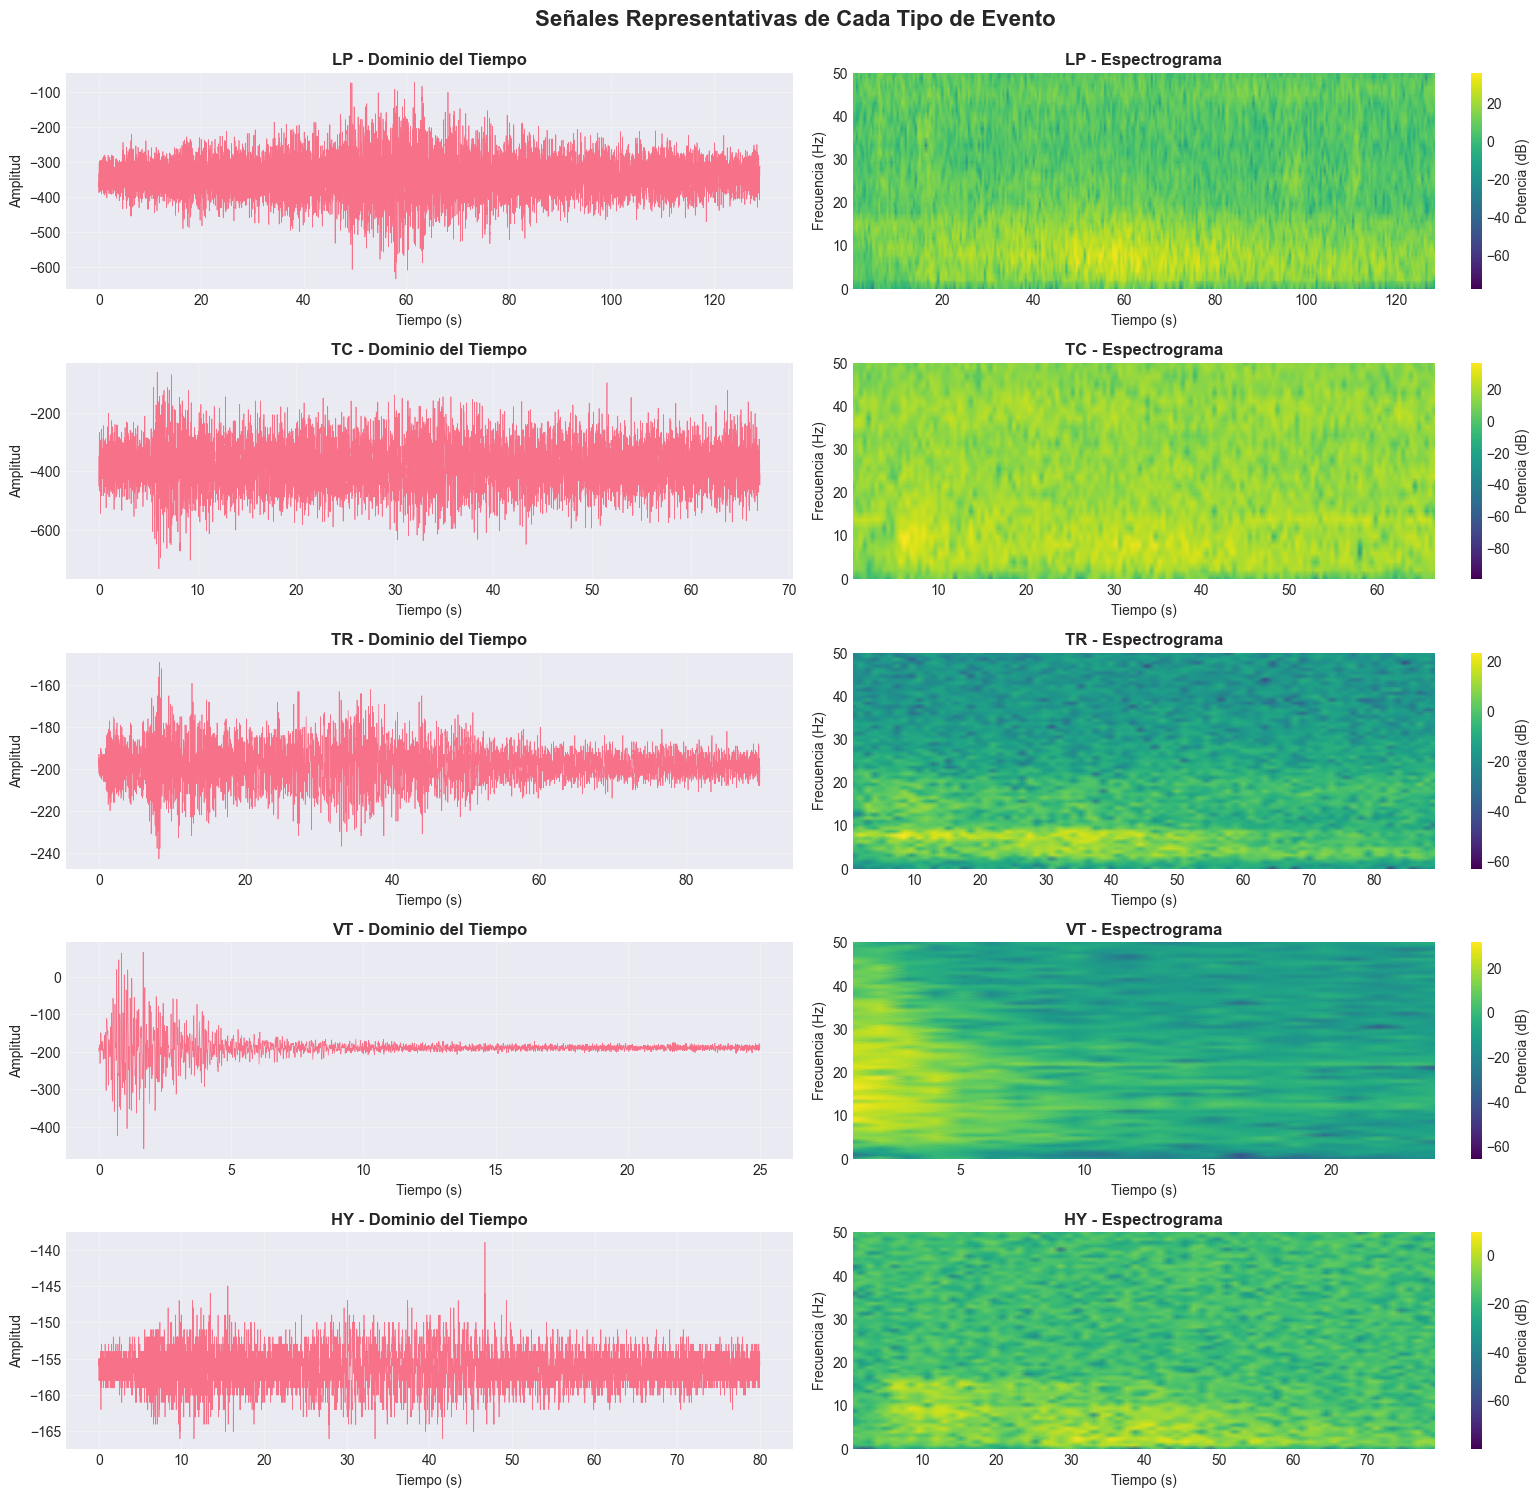

In [ ]:

representative_events = {}

for event_type in event_types_list:
    subset = df_features[df_features['tipo'] == event_type]
    subset_features = subset[feature_cols].fillna(0)
    
    
    centroid = subset_features.mean().values
    distances = np.linalg.norm(subset_features.values - centroid, axis=1)
    
    
    idx_representative = subset.iloc[np.argmin(distances)]
    representative_events[event_type] = idx_representative['archivo']


fig, axes = plt.subplots(len(event_types_list), 2, figsize=(16, 3*len(event_types_list)))

fig.suptitle('Señales Representativas de Cada Tipo de Evento', 
             fontsize=16, fontweight='bold', y=0.995)

for idx, event_type in enumerate(event_types_list):
    archivo = representative_events[event_type]
    file_path = LABELED_DATA / event_type / archivo
    
    try:
        st = obspy.read(str(file_path))
        tr = st[0]
        data = tr.data
        fs = tr.stats.sampling_rate
        time = np.arange(len(data)) / fs
        
        
        axes[idx, 0].plot(time, data, linewidth=0.5)
        axes[idx, 0].set_title(f'{event_type} - Dominio del Tiempo', 
                               fontsize=12, fontweight='bold')
        axes[idx, 0].set_xlabel('Tiempo (s)')
        axes[idx, 0].set_ylabel('Amplitud')
        axes[idx, 0].grid(True, alpha=0.3)
        
        
        f, t, Sxx = signal.spectrogram(data, fs, nperseg=256)
        im = axes[idx, 1].pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
        axes[idx, 1].set_title(f'{event_type} - Espectrograma', 
                               fontsize=12, fontweight='bold')
        axes[idx, 1].set_xlabel('Tiempo (s)')
        axes[idx, 1].set_ylabel('Frecuencia (Hz)')
        axes[idx, 1].set_ylim(0, min(50, fs/2))  
        plt.colorbar(im, ax=axes[idx, 1], label='Potencia (dB)')
        
    except Exception as e:
        print(f"Error al cargar {archivo}: {e}")

plt.tight_layout()
fig_path = FIGURES_DIR / "senales_representativas_por_tipo.png"
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Gráfico guardado en: {fig_path}")
plt.show()